In [159]:
import pandas as pd
import numpy as np
import data_handler
from tqdm import tqdm
import matplotlib.pyplot as plt

from torchvision import datasets
import os
from itertools import chain, product

from scipy.stats import ttest_1samp, ttest_rel, t
from scipy import stats

In [160]:
DATA_PATH = os.path.join(os.path.curdir, "data", "survey_results", "data_tu-helpfulness-of-xai_2022-07-13_13-03.xlsx")
DATA_PREPARED_PATH = f"{os.path.splitext(DATA_PATH)[0]}_PREPARED{os.path.splitext(DATA_PATH)[1]}"
df = pd.read_excel(DATA_PATH)
df_merged = pd.read_excel(DATA_PREPARED_PATH)

In [161]:
META_DATA_PATH = os.path.join(os.path.curdir, "data", "survey_results", "question_meta_data.xlsx")
df_quest_meta = pd.read_excel(META_DATA_PATH)

# Evaluation Metrics Calculation & Testing

### Metric functions

In [162]:
def accuracy_per_groupby(df_merged, group_by=["method"], drop_na=False):
    # accuracy = (TP + TN) / (TP + TN + FP + FN)
    schema_cols = [df_merged[column].drop_duplicates() for column in group_by + ["is_pred_correct", "response"]]
    schema_col_names = [ser.name for ser in schema_cols]
    df_schema = pd.DataFrame(list(product(*schema_cols))).groupby(list(np.arange(len(schema_cols)))).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=schema_col_names
    
    ser_denominators = df_merged.groupby(by=group_by, dropna=drop_na)["response"].count().sort_index()
    df_numerators = df_merged.groupby(by=group_by + ["is_pred_correct", "response"], dropna=drop_na)["response"].count().to_frame("count").reset_index()
    df_numerators = df_schema.merge(right=df_numerators, on=schema_col_names, how="left").fillna(0)
    ser_numerators = df_numerators[df_numerators["is_pred_correct"] == df_numerators["response"]].groupby(group_by, dropna=drop_na)["count"].sum().sort_index()
    df_accuracies = (ser_numerators / ser_denominators).to_frame("accuracy")
    return df_accuracies

In [163]:
def sensitivity_per_groupby(df_merged, group_by=["method"], drop_na=True):
    # sensitivity = TP / (TP + FN)
    schema_cols = [df_merged[column].drop_duplicates() for column in group_by + ["is_pred_correct", "response"]]
    schema_col_names = [ser.name for ser in schema_cols]
    df_schema = pd.DataFrame(list(product(*schema_cols))).groupby(list(np.arange(len(schema_cols)))).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=schema_col_names
    
    df_merged_filt = df_merged[(df_merged["is_pred_correct"] == True)]
    ser_denominators = df_merged_filt.groupby(by=group_by, dropna=drop_na)["response"].count().sort_index()
    df_numerators = df_merged_filt.groupby(by=group_by + ["is_pred_correct", "response"], dropna=drop_na)["response"].count().to_frame("count").reset_index()
    df_numerators = df_schema.merge(right=df_numerators, on=schema_col_names, how="left").fillna(0)
    ser_numerators = df_numerators[df_numerators["is_pred_correct"] == df_numerators["response"]].groupby(group_by, dropna=drop_na)["count"].sum().sort_index()
    df_sensitivity = (ser_numerators / ser_denominators).to_frame("sensitivity")
    return df_sensitivity

In [164]:
def specificity_per_groupby(df_merged, group_by=["method"], drop_na=True):
    # specificity = TN / (TN + FP)
    schema_cols = [df_merged[column].drop_duplicates() for column in group_by + ["is_pred_correct", "response"]]
    schema_col_names = [ser.name for ser in schema_cols]
    df_schema = pd.DataFrame(list(product(*schema_cols))).groupby(list(np.arange(len(schema_cols)))).count()
    df_schema = df_schema.reset_index()
    df_schema.columns=schema_col_names
    
    df_merged_filt = df_merged[(df_merged["is_pred_correct"] == False)]
    ser_denominators = df_merged_filt.groupby(by=group_by, dropna=drop_na)["response"].count().sort_index()
    df_numerators = df_merged_filt.groupby(by=group_by + ["is_pred_correct", "response"], dropna=drop_na)["response"].count().to_frame("count").reset_index()
    df_numerators = df_schema.merge(right=df_numerators, on=schema_col_names, how="left").fillna(0)
    ser_numerators = df_numerators[df_numerators["is_pred_correct"] == df_numerators["response"]].groupby(group_by, dropna=drop_na)["count"].sum().sort_index()
    df_specificity = (ser_numerators / ser_denominators).to_frame("specificity")
    return df_specificity

In [165]:
def get_metric_convergence(df_metric):
    metric_name = df_metric.columns[0]
    return df_metric.groupby(level=0).expanding().mean().reset_index(level=[1, 2]).\
            pivot(index="case", columns="method", values=metric_name)

### Plotting functions

In [166]:
def plot_metric_value_frequencies(df_metric_freq, df_metric_means, metric="Accuracy", size=(16, 4)):
    ax = df_metric_freq[df_metric_means.index].transpose().plot.bar(figsize=size)
    ax.set_ylabel(f"Number Participants who reached {metric} score")
    ax.xaxis.set_tick_params(rotation=0)

In [167]:
def plot_metric_boxplot(df_metrics_pivot, xlabel="XAI-Method", ylabel="Accuracy", title="", size=(16, 4)):
    metric_mean_sorted = df_metrics_pivot.mean(axis=0).sort_values(ascending=False)
    xai_mean_sorted = metric_mean_sorted.index.values
    df_metrics_pivot = df_metrics_pivot[xai_mean_sorted]
    ax, bp = df_metrics_pivot.boxplot(figsize=size, showmeans=True, meanline=True, medianprops={"color":"red"}, return_type="both")
    
    m1 = df_metrics_pivot.mean()
    for i, line in enumerate(bp['means']):
        x, y = line.get_xydata()[0]
        y = y * 1.01
        text = f"mean = {metric_mean_sorted[i].round(2)}"
        ax.annotate(text, xy=(x, y))
        
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yticks(pd.unique(df_metrics_pivot.to_numpy().flatten()))
    ax.grid(axis="x")
    plt.show()
    plt.close()

In [168]:
def plot_metric_freq_and_boxplot(df_metric_freq, df_metric_means, df_metrics_pivot, metric="Accuracy", size=(10, 7)):
    xai_mean_sorted = df_metric_means.index.values
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=size)
    df_metric_freq[xai_mean_sorted].transpose().plot.bar(ax=ax1)
    ax1.set_ylabel(f"Number Participants who reached \n {metric} Score")
    ax1.xaxis.set_tick_params(rotation=0)
    ax1.set_xlabel("")
    ax1.legend(edgecolor="black")

    df_metrics_pivot = df_metrics_pivot[xai_mean_sorted]
    bp = df_metrics_pivot.boxplot(figsize=size, showmeans=True, meanline=True, medianprops={"color":"red"}, return_type="dict", ax=ax2)
    
    m1 = df_metrics_pivot.mean()
    for i, line in enumerate(bp['means']):
        x, y = line.get_xydata()[0]
        y = y * 1.01
        mean = df_metric_means.values[i][0].round(2)
        format_float="{:.2f}".format(mean)
        text = f"mean = {format_float}"
        ax2.annotate(text, xy=(x, y))
        
    ax2.set_ylabel(metric)
    ax2.set_yticks(pd.unique(df_metrics_pivot.to_numpy().flatten())) # np.arange(0, 1.1, 0.1)
    ax2.grid(axis="x")
    fig.supxlabel("XAI Method", y=0.02)
    plt.tight_layout()
    plt.savefig(f"freq_boxplot_{metric.lower()}.pdf")

In [169]:
def plot_acc_sens_spec(df_acc_mean, df_sens_mean, df_spec_mean, title_addition="", size=(10, 4)):
    xai_acc_sorted = df_acc_mean.sort_values(by="mean", ascending=False).index.values
    df_acc_mean = df_acc_mean.reindex(xai_acc_sorted)
    df_sens_mean = df_sens_mean.reindex(xai_acc_sorted)
    df_spec_mean = df_spec_mean.reindex(xai_acc_sorted)
    
    fig, ax = plt.subplots(figsize=size)
    ax.scatter(x=df_acc_mean.index, y=df_acc_mean, c="black", label="Accuracy", marker="s")
    ax.scatter(x=df_sens_mean.index, y=df_sens_mean, c="darkorange", label="Sensitivity")
    ax.scatter(x=df_spec_mean.index, y=df_spec_mean, c="olivedrab", label="Specificity", marker="^")
    ax.plot(df_sens_mean["mean"].index, [0.5] * len(df_sens_mean), color="indianred", linestyle='dashed', label="baseline")
    #ax.set_title(f"{title_addition} Performance Ratios for chosen XAI-Methods ({len(df)-1} participants considered)", size=15)
    ax.set_xlabel("XAI-Method", size=13)
    ax.set_ylabel("Ratio", size=13)
    for i, txt in enumerate(df_acc_mean["mean"].round(2)):
        ax.annotate(txt, (list(df_acc_mean.index)[i], list(df_acc_mean["mean"])[i]))
    for i, txt in enumerate(df_sens_mean["mean"].round(2)):
        ax.annotate(txt, (list(df_sens_mean.index)[i], list(df_sens_mean["mean"])[i]))
    for i, txt in enumerate(df_spec_mean["mean"].round(2)):
        ax.annotate(txt, (list(df_spec_mean.index)[i], list(df_spec_mean["mean"])[i]))
    ax.legend(loc="best", edgecolor="black")
    ax.tick_params(labelright=True)
    ax.yaxis.set_ticks_position('both')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    plt.tight_layout()
    plt.savefig("metrics_overview.pdf") # sens_vs_spec.svg

In [170]:
def plot_metric_convergence(df_metrics_conv, metric_name="Accuracy"):
    methods_sorted = df_metrics_conv.iloc[-1].sort_values(ascending=False).index.values
    df_metrics_conv = df_metrics_conv[methods_sorted]
    
    methods_names = methods_sorted.copy()
    methods_names.sort()
    colors =["darkorange", "olivedrab","lightseagreen","darkslategrey","royalblue","mediumvioletred"]
    line = ["dotted","dashed","dashdot","dotted","dashed","dashdot"]
    colors_dict = dict(zip(methods_names, colors))
    line_dict = dict(zip(methods_sorted, line))
    
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.set_xlabel("Number Participants", size=13)
    ax.set_ylabel(metric_name, size=13)
    #ax.set_title(f"Convergence of {metric_name} as Number of Participants increase", size=15)
    df_metrics_conv.apply(lambda method_conv: ax.plot(list(range(len(method_conv))), method_conv, label=method_conv.name, color=colors_dict[method_conv.name],ls=line_dict[method_conv.name]))
    ax.legend(loc="upper right", edgecolor="black")
    ax.tick_params(labelright=True)
    ax.yaxis.set_ticks_position('both')
    plt.savefig("convergence.pdf")

In [171]:
def plot_2_indexes_1_plot(df_double_index, xlabel, ylabel, title, drop_na=True, drop_duplicates=True, mean_idx_order=None):
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))
    plt.setp(ax, ylim=(0, 1.1))
    if drop_duplicates:
        ser_level_1_count = df_merged.drop_duplicates("case").groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()
    else:
        ser_level_1_count = df_merged.groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()
                                                                                                                            
    ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]
    # reorder bars in barplot as specified
    if mean_idx_order:
        ser_acc_mean = ser_acc_mean.reindex(mean_idx_order)
                                                                                                                         
    pps = ax[0].bar(ser_acc_mean.index, ser_acc_mean)
    for p in pps:
        height = p.get_height()
        ax[0].text(x=p.get_x() + p.get_width() / 2, y=height+.05,
          s=round(height, 2),
          ha='center', size=12)
    ax[0].set_xlabel(ser_acc_mean.index.name, size=15)
    ax[0].set_ylabel("Accuracy", size=15)
    ax[0].set_title(f"Mean Accuracy over all XAI-Methods per {ser_acc_mean.index.name}", size=20)
    
    for idx_level_1 in df_double_index.index.levels[0]:
        ax[1].plot(df_double_index.loc[idx_level_1].index, list(df_double_index.loc[idx_level_1][df_double_index.columns[0]]), label=f"{idx_level_1} ({ser_level_1_count[idx_level_1]})")
        ax[1].scatter(df_double_index.loc[idx_level_1].index, list(df_double_index.loc[idx_level_1][df_double_index.columns[0]]))
    ax[1].legend()
    ax[1].set_xlabel(xlabel, size=15)
    ax[1].set_ylabel(ylabel, size=15)
    ax[1].set_title(title, size=20)
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.4)
    plt.show()
    plt.close()

In [172]:
def bar_plot(df_double_index,filename ,drop_na=True, drop_duplicates=True, mean_idx_order=None):
    fig, ax = plt.subplots(figsize=(14, 5))
    if drop_duplicates:
        ser_level_1_count = df_merged.drop_duplicates("case").groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()
    else:
        ser_level_1_count = df_merged.groupby(df_double_index.index.levels[0].name, dropna=drop_na)[df_merged.columns[0]].count()

    ser_acc_mean = df_double_index.mean(level=0)[df_double_index.columns[0]]
    # reorder bars in barplot as specified
    if mean_idx_order:
        ser_acc_mean = ser_acc_mean.reindex(mean_idx_order)

    pps = ax.bar(ser_acc_mean.index, ser_acc_mean,color="olivedrab")
    for p in pps:
        height = p.get_height()
        ax.text(x=p.get_x() + p.get_width() / 2, y=height+.05,
          s=round(height, 2),
          ha='center', size=12)
    ax.set_xlabel(ser_acc_mean.index.name, size=15)
    ax.set_ylabel("Accuracy", size=15)
    #ax.set_title(f"Mean Accuracy over all XAI-Methods per {ser_acc_mean.index.name}", size=20)
    ax.tick_params(labelright=True)
    ax.set_ylim([0, 1])
    plt.savefig(filename+".svg")
    plt.show()
    plt.close()

In [173]:
def line_plot(df_double_index, xlabel, ylabel,filename, drop_na=True):
    fig, ax = plt.subplots(figsize=(14, 5))

    colors =["darkorange","olivedrab"]
    line = ["dashed","dashdot"]
    idx_level_1 = df_double_index.index.levels[0]

    for i in range(idx_level_1.shape[0]):
        ax.plot(df_double_index.loc[idx_level_1[i]].index, list(df_double_index.loc[idx_level_1[i]][df_double_index.columns[0]]),
                label=f"{idx_level_1[i]}",color=colors[i],ls=line[i]) #({ser_level_1_count[idx_level_1]})
        ax.scatter(df_double_index.loc[idx_level_1[i]].index, list(df_double_index.loc[idx_level_1[i]][df_double_index.columns[0]]),
                   color=colors[i])
    ax.legend(loc="upper right")
    ax.set_xlabel(xlabel, size=13)
    ax.set_ylabel(ylabel, size=13)
    ax.set_ylim([0, 1])
    ax.tick_params(labelright=True)
    plt.savefig(filename+".svg")
    plt.show()
    plt.close()

### Testing & effect size functions

In [174]:
# isn't used currently
def print_test_result(pval, alpha, mean_h_0):
    print(f"p-value: {pval}")
    if pval < alpha:
        print(f"Reject H0: accuracy_mean <= {mean_h_0} \n")
    else:
        print("Can't reject H0 \n")

In [175]:
def perform_t_test(accuracies, mean_h_0, alpha, alternative):
    tset, pval = ttest_1samp(a=accuracies, popmean=mean_h_0, alternative=alternative)
    print(accuracies.name)
    print(f"p-value: {pval.round(3)}")
    if pval < alpha:
        print(f"Reject H0: accuracy_mean <= {mean_h_0} \n")
    else:
        print("Can't reject H0 \n")
    return tset

In [176]:
def perform_t_test_with_flexible_alternative(metrics, mean_h_0, alpha):
    h_a = None
    sample_mean = metrics.mean()
    if sample_mean < mean_h_0:
        h_a = "less"
    elif sample_mean > mean_h_0:
        h_a = "greater"
    else:
        h_a = "two-sided"
    tset, pval = ttest_1samp(a=metrics, popmean=mean_h_0, alternative=h_a)
    
    h_a_to_h_0_mapping = {"less": ">=", "greater": "<=", "two-sided": "equal"}
    print(f"{metrics.name}:  sample_mean={sample_mean}")
    print(f"H0: sample_mean {h_a_to_h_0_mapping[h_a]} {mean_h_0}")
    print(f"p-value: {pval.round(3)}")
    if pval < alpha:
        print(f"Reject H0! (alpha={alpha})\n")
    else:
        print(f"CAN'T reject H0: (alpha={alpha})\n")
    return tset

In [177]:
def get_pairwise_paired_test_results(df_metrics, df_metrics_mean, ALPHA):
    paired_test_alternatives = []
    paired_test_pvalues = []
    df_metrics_mean = df_metrics_mean.sort_values(by="mean", ascending=False)
    xai_accuracy_sorted = df_metrics_mean.index.values
    for method_i in xai_accuracy_sorted:
        method_i_alternatives = []
        method_i_pvalues = []
        for method_j in xai_accuracy_sorted:
            h_a = None
            if df_metrics_mean.loc[method_i]["mean"] < df_metrics_mean.loc[method_j]["mean"]:
                h_a = "less"
            elif df_metrics_mean.loc[method_i]["mean"] > df_metrics_mean.loc[method_j]["mean"]:
                h_a = "greater"
            elif (df_metrics_mean.loc[method_i]["mean"] == df_metrics_mean.loc[method_j]["mean"]) & (method_i != method_j):
                h_a = "two-sided"
            method_i_alternatives.append(h_a)
            if h_a is None:
                method_i_pvalues.append(None)
            else:
                a = df_metrics[method_i].values
                b = df_metrics[method_j].values
                tset, pval = ttest_rel(a, b, alternative=h_a)
                method_i_pvalues.append(pval)
        paired_test_alternatives.append(method_i_alternatives)
        paired_test_pvalues.append(method_i_pvalues)
        
    def alternative_formatter(x):
        alt_str = None
        if  x=="less":
            alt_str = "$<$" 
        elif x=="greater":
            alt_str = "$>$"
        else:
            alt_str = "—"
        return alt_str
        
    def p_value_formatter(x):
        pval_str = None
        if x < 0.001:
            pval_str = "$<$ .001"
        elif np.isnan(x):
            pval_str = "—"
        else:
            pval_str = f".{str(round(x, 3)).split('.')[-1]}"
        return pval_str
            
    
    df_paired_alternatives = pd.DataFrame(paired_test_alternatives, index=xai_accuracy_sorted, columns=xai_accuracy_sorted)
    df_paired_alternatives = df_paired_alternatives.applymap(alternative_formatter)
    df_paired_pvalues = pd.DataFrame(paired_test_pvalues, index=xai_accuracy_sorted ,columns=xai_accuracy_sorted)
    df_paired_decision = df_paired_pvalues < ALPHA
    df_paired_pvalues = df_paired_pvalues.applymap(p_value_formatter)
    
    return df_paired_alternatives, df_paired_pvalues, df_paired_decision

In [178]:
# Cohen’s d for one-sample t-test
def cohens_d(t_statistic, N):
    return t_statistic / np.sqrt(N)

### Constants

In [179]:
# significance level
ALPHA = 0.05
mean_h_0 = 0.5

## 1. Accuracies

In [180]:
df_acc = accuracy_per_groupby(df_merged, group_by=["method", "case"])
df_acc_pivot = df_acc.reset_index().pivot(index="case", columns="method", values="accuracy")
df_acc_frequencies = df_acc_pivot.apply(lambda x: x.value_counts())
df_acc_conv = get_metric_convergence(df_acc)
df_acc_mean = df_acc_pivot.mean().to_frame("mean").sort_values(by="mean", ascending=False)

### Accuracy boxplots

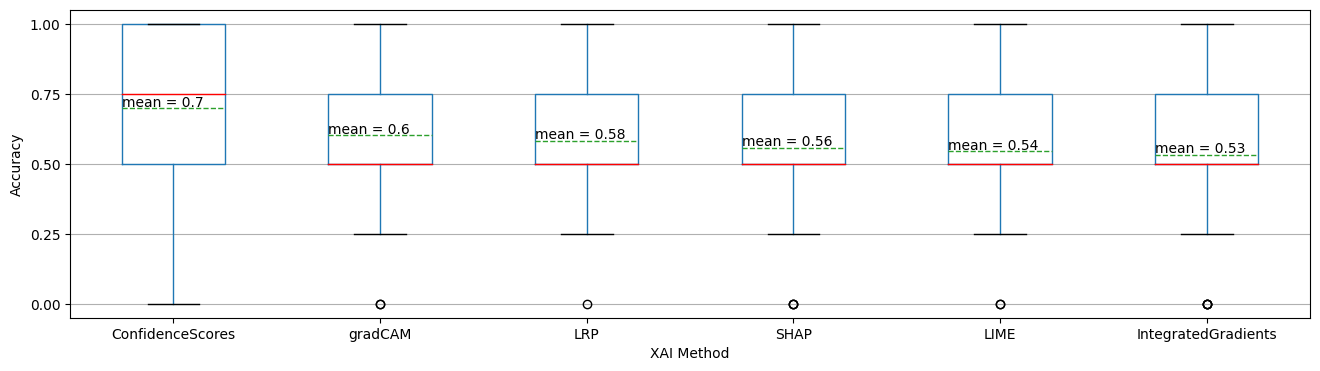

In [181]:
plot_metric_boxplot(df_acc_pivot, xlabel="XAI Method", title="", )

### Accuracy convergence

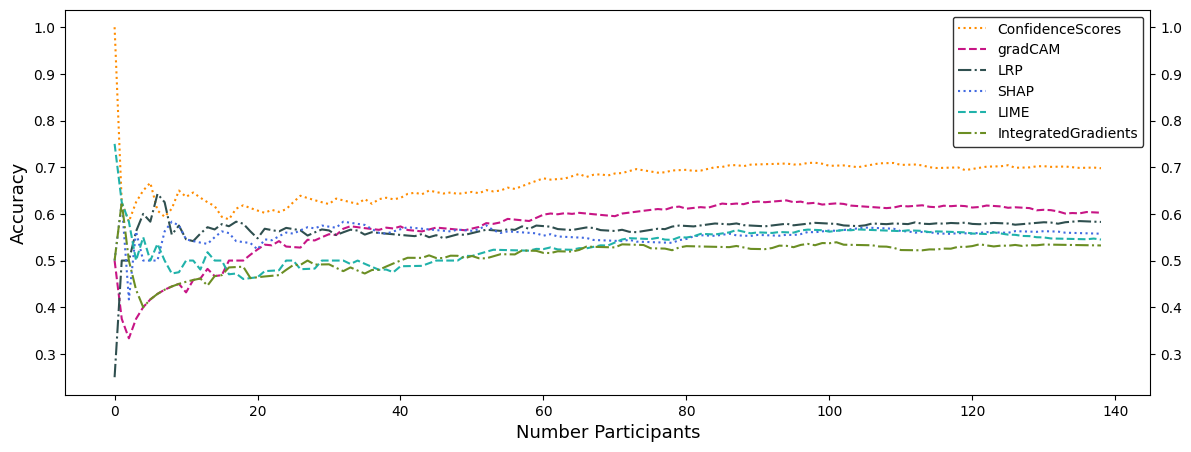

In [182]:
plot_metric_convergence(df_acc_conv)

### Accuracy values  frequencies (all possible discrete according to question resolution)

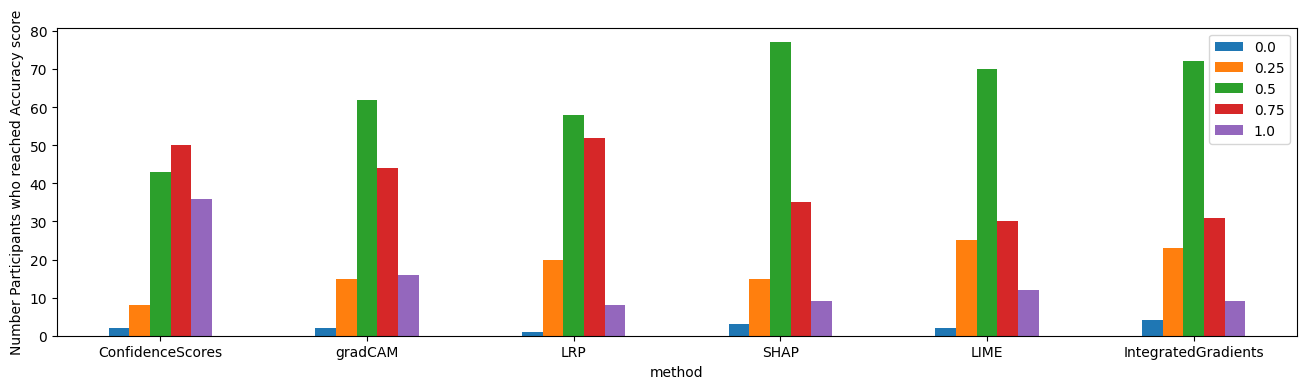

In [183]:
ax_acc_freq = plot_metric_value_frequencies(df_acc_frequencies, df_acc_mean)

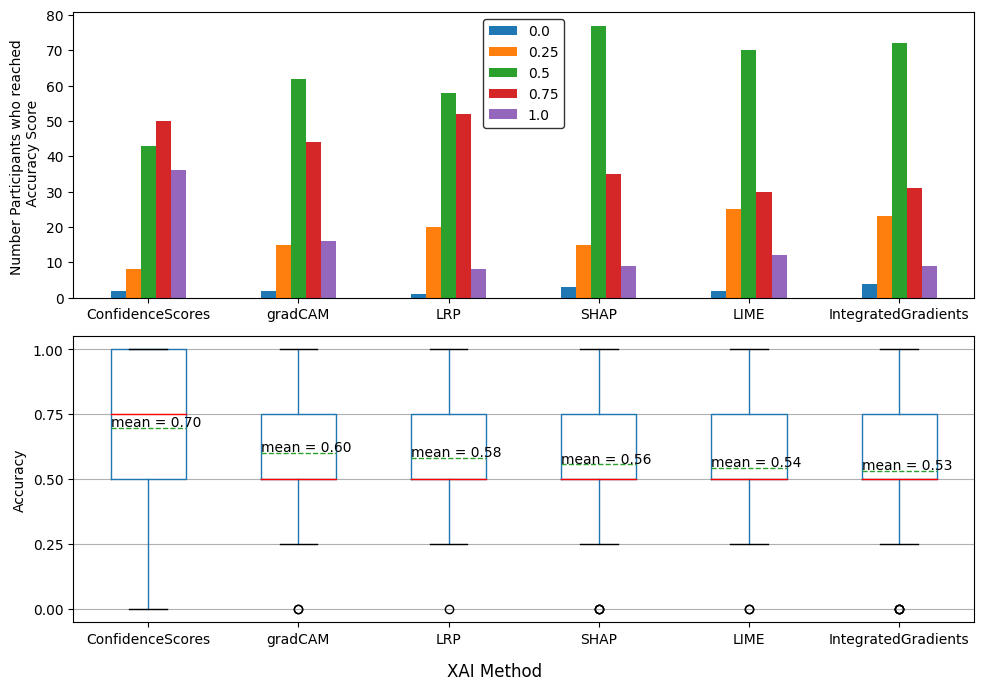

In [184]:
plot_metric_freq_and_boxplot(df_acc_frequencies, df_acc_mean, df_acc_pivot, metric="Accuracy")

### Significance & Effect Size: Accuracy comparisons to random baseline

In [241]:
df_acc_mean.round(2)

,mean
method,
ConfidenceScores,0.70
gradCAM,0.60
LRP,0.58
SHAP,0.56
LIME,0.54
IntegratedGradients,0.53


#### 1-sample t-test

In [185]:
# test with flexibile alternative
ser_acc_1_sample_t_values = df_acc_pivot.apply(lambda accuracies_method: perform_t_test_with_flexible_alternative(accuracies_method, mean_h_0, ALPHA))

ConfidenceScores:  sample_mean=0.697841726618705
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

IntegratedGradients:  sample_mean=0.5323741007194245
H0: sample_mean <= 0.5
p-value: 0.04
Reject H0! (alpha=0.05)

LIME:  sample_mean=0.5449640287769785
H0: sample_mean <= 0.5
p-value: 0.009
Reject H0! (alpha=0.05)

LRP:  sample_mean=0.5827338129496403
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

SHAP:  sample_mean=0.5575539568345323
H0: sample_mean <= 0.5
p-value: 0.001
Reject H0! (alpha=0.05)

gradCAM:  sample_mean=0.6025179856115108
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)



#### Effect size (Cohens d) 

In [186]:

N_acc = df_acc_pivot.shape[0]
df_acc_1_sample_effect = ser_acc_1_sample_t_values.map(lambda t_val: cohens_d(t_val, N_acc)).to_frame("cohens_d").sort_values(by="cohens_d", ascending=False)

In [187]:
df_acc_1_sample_effect.round(2)

,cohens_d
method,
ConfidenceScores,0.84
gradCAM,0.46
LRP,0.40
SHAP,0.28
LIME,0.20
IntegratedGradients,0.15


### Significance: Accuracies pairwise between each other

#### Paired t-test

In [188]:
df_acc_paired_test_alternatives, df_acc_paired_test_pvalues, df_acc_paired_test_decision = get_pairwise_paired_test_results(df_acc_pivot, df_acc_mean, ALPHA)

In [189]:
df_acc_paired_test_alternatives

,ConfidenceScores,gradCAM,LRP,SHAP,LIME,IntegratedGradients
ConfidenceScores,—,$>$,$>$,$>$,$>$,$>$
gradCAM,$<$,—,$>$,$>$,$>$,$>$
LRP,$<$,$<$,—,$>$,$>$,$>$
SHAP,$<$,$<$,$<$,—,$>$,$>$
LIME,$<$,$<$,$<$,$<$,—,$>$
IntegratedGradients,$<$,$<$,$<$,$<$,$<$,—


In [190]:
print(df_acc_paired_test_alternatives.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} & ConfidenceScores & gradCAM &  LRP & SHAP & LIME & IntegratedGradients \\
\midrule
ConfidenceScores    &                — &     $>$ &  $>$ &  $>$ &  $>$ &                 $>$ \\
gradCAM             &              $<$ &       — &  $>$ &  $>$ &  $>$ &                 $>$ \\
LRP                 &              $<$ &     $<$ &    — &  $>$ &  $>$ &                 $>$ \\
SHAP                &              $<$ &     $<$ &  $<$ &    — &  $>$ &                 $>$ \\
LIME                &              $<$ &     $<$ &  $<$ &  $<$ &    — &                 $>$ \\
IntegratedGradients &              $<$ &     $<$ &  $<$ &  $<$ &  $<$ &                   — \\
\bottomrule
\end{tabular}



/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_77024/1130788565.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_acc_paired_test_alternatives.to_latex(escape=False))


In [191]:
df_acc_paired_test_pvalues

,ConfidenceScores,gradCAM,LRP,SHAP,LIME,IntegratedGradients
ConfidenceScores,—,$<$ .001,$<$ .001,$<$ .001,$<$ .001,$<$ .001
gradCAM,$<$ .001,—,.204,.031,.009,.005
LRP,$<$ .001,.204,—,.149,.051,.02
SHAP,$<$ .001,.031,.149,—,.301,.139
LIME,$<$ .001,.009,.051,.301,—,.312
IntegratedGradients,$<$ .001,.005,.02,.139,.312,—


In [228]:
print(df_acc_paired_test_pvalues.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} & ConfidenceScores &   gradCAM &       LRP &      SHAP &      LIME & IntegratedGradients \\
\midrule
ConfidenceScores    &                — &  $<$ .001 &  $<$ .001 &  $<$ .001 &  $<$ .001 &            $<$ .001 \\
gradCAM             &         $<$ .001 &         — &      .204 &      .031 &      .009 &                .005 \\
LRP                 &         $<$ .001 &      .204 &         — &      .149 &      .051 &                 .02 \\
SHAP                &         $<$ .001 &      .031 &      .149 &         — &      .301 &                .139 \\
LIME                &         $<$ .001 &      .009 &      .051 &      .301 &         — &                .312 \\
IntegratedGradients &         $<$ .001 &      .005 &       .02 &      .139 &      .312 &                   — \\
\bottomrule
\end{tabular}



/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_77024/2053531877.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_acc_paired_test_pvalues.to_latex(escape=False))


In [193]:
df_acc_paired_test_decision

,ConfidenceScores,gradCAM,LRP,SHAP,LIME,IntegratedGradients
ConfidenceScores,False,True,True,True,True,True
gradCAM,True,False,False,True,True,True
LRP,True,False,False,False,False,True
SHAP,True,True,False,False,False,False
LIME,True,True,False,False,False,False
IntegratedGradients,True,True,True,False,False,False


## 2. Sensitivity

In [194]:
df_sens = sensitivity_per_groupby(df_merged, group_by=["method", "case"])
df_sens_pivot = df_sens.reset_index().pivot(index="case", columns="method", values="sensitivity")
df_sens_frequencies = df_sens_pivot.apply(lambda x: x.value_counts())
df_sens_conv = get_metric_convergence(df_sens)
df_sens_mean = df_sens_pivot.mean().to_frame("mean").sort_values(by="mean", ascending=False)

### Sensitivity boxplots

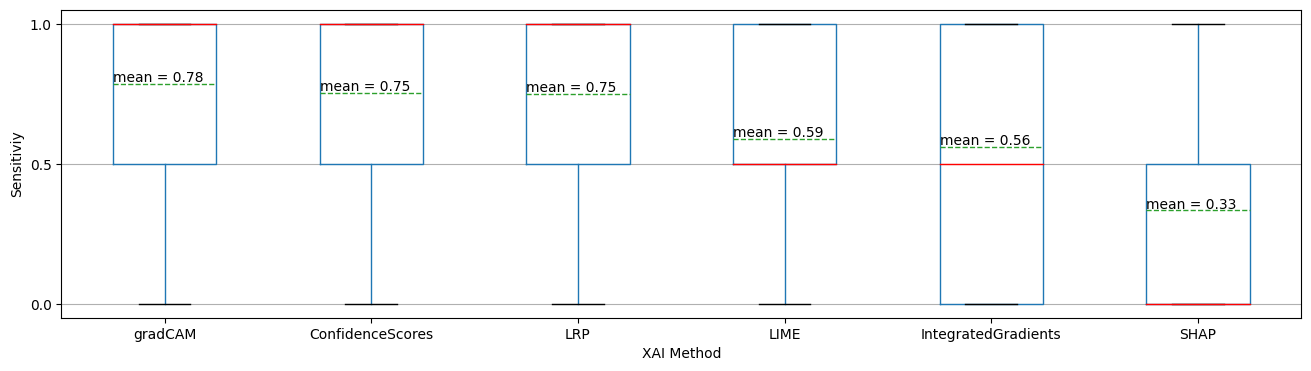

In [197]:
title = "" # "Sensitivity Variance among Participants per XAI-Method"
plot_metric_boxplot(df_sens_pivot, xlabel= "XAI Method", ylabel="Sensitiviy", title=title)

### Sensitvity convergence

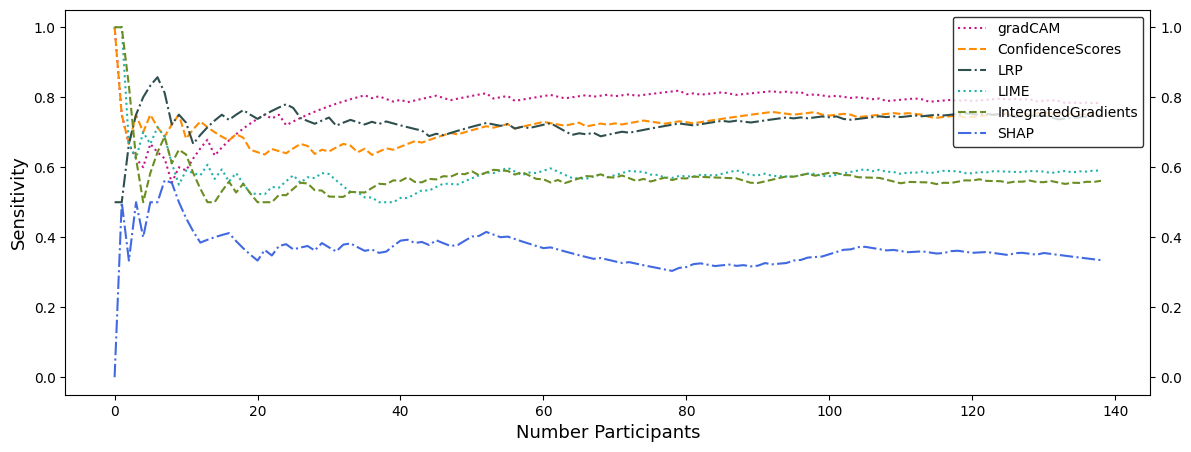

In [198]:
plot_metric_convergence(df_sens_conv, metric_name="Sensitivity")

### Sensitivity values  frequencies (all possible discrete according to question resolution)

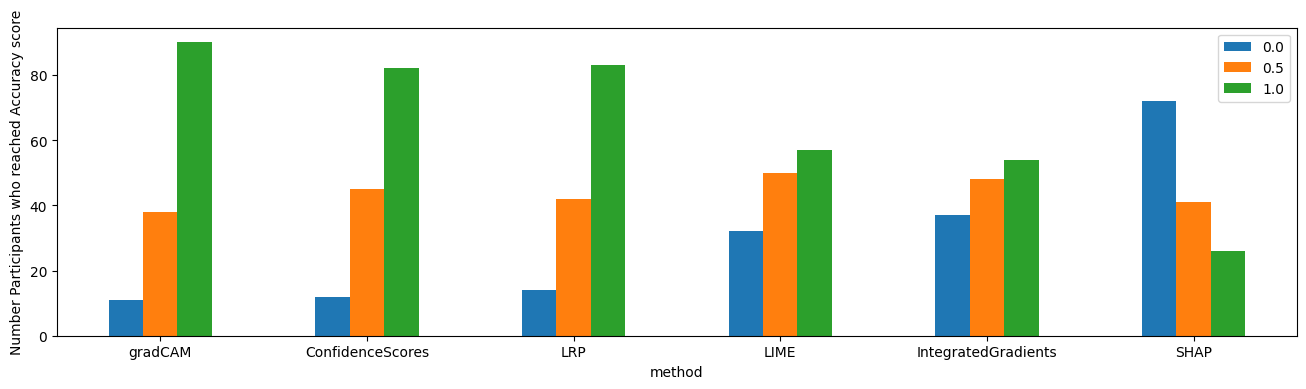

In [199]:
plot_metric_value_frequencies(df_sens_frequencies, df_sens_mean)

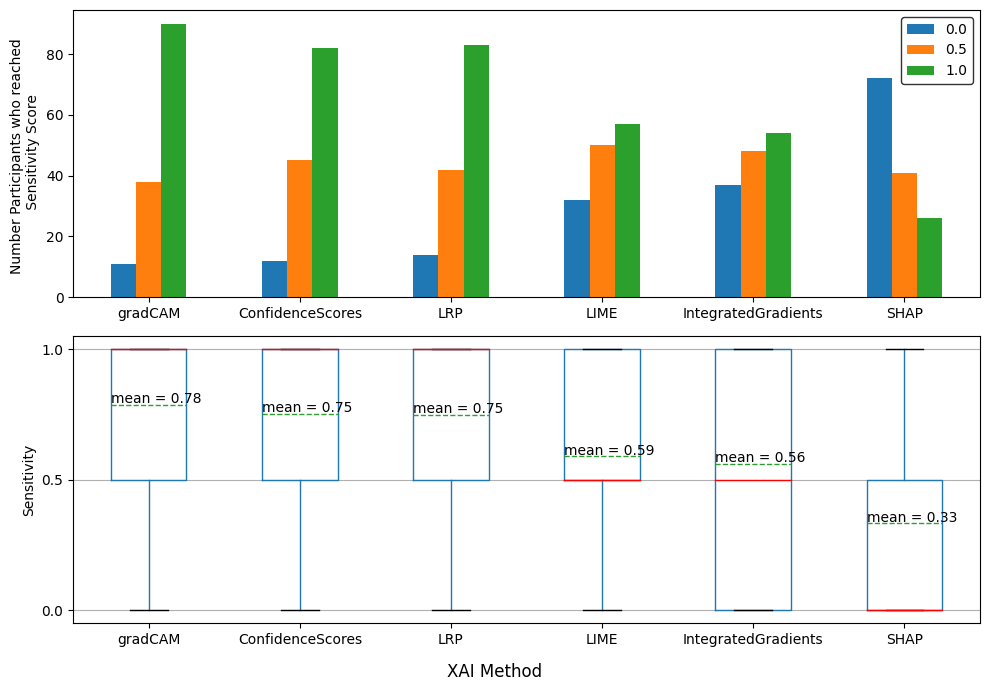

In [200]:
plot_metric_freq_and_boxplot(df_sens_frequencies, df_sens_mean, df_sens_pivot, metric="Sensitivity")

### Significance & Effect Size: Sensitivity comparisons to random baseline

In [244]:
df_sens_mean.round(2)

,mean
method,
gradCAM,0.78
ConfidenceScores,0.75
LRP,0.75
LIME,0.59
IntegratedGradients,0.56
SHAP,0.33


#### 1-sample t-test

In [201]:
# test with flexibile alternative
ser_sens_1_sample_t_values = df_sens_pivot.apply(lambda metric_method: perform_t_test_with_flexible_alternative(metric_method, mean_h_0, ALPHA))

ConfidenceScores:  sample_mean=0.7517985611510791
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

IntegratedGradients:  sample_mean=0.5611510791366906
H0: sample_mean <= 0.5
p-value: 0.037
Reject H0! (alpha=0.05)

LIME:  sample_mean=0.5899280575539568
H0: sample_mean <= 0.5
p-value: 0.004
Reject H0! (alpha=0.05)

LRP:  sample_mean=0.7482014388489209
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

SHAP:  sample_mean=0.3345323741007194
H0: sample_mean >= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

gradCAM:  sample_mean=0.7841726618705036
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)



In [202]:
# overall test
df_sens_overall = df_sens_pivot.mean(axis=1)
t_sens_overall = perform_t_test(df_sens_overall, mean_h_0, ALPHA, "greater")
effect_sens_overall = cohens_d(t_sens_overall, len(df_sens_overall))
effect_sens_overall

None
p-value: 0.0
Reject H0: accuracy_mean <= 0.5 



0.7202525778433363

In [203]:
df_sens_overall.mean()

0.6282973621103116

#### Effect size (Cohens d) 

In [204]:
N_sens = df_sens_pivot.shape[0]
df_sens_1_sample_effect = ser_sens_1_sample_t_values.map(lambda t_val: cohens_d(t_val, N_sens)).to_frame("cohens_d").sort_values(by="cohens_d", ascending=False)

In [205]:
df_sens_1_sample_effect.round(2)

,cohens_d
method,
gradCAM,0.89
ConfidenceScores,0.77
LRP,0.74
LIME,0.23
IntegratedGradients,0.15
SHAP,-0.43


### Significance: Sensitivity pairwise between in each other

#### Paired t-test

In [206]:
df_sens_paired_test_alternatives, df_sens_paired_test_pvalues, df_sens_paired_test_decision = get_pairwise_paired_test_results(df_sens_pivot, df_sens_mean, ALPHA)


In [207]:
df_sens_paired_test_alternatives

,gradCAM,ConfidenceScores,LRP,LIME,IntegratedGradients,SHAP
gradCAM,—,$>$,$>$,$>$,$>$,$>$
ConfidenceScores,$<$,—,$>$,$>$,$>$,$>$
LRP,$<$,$<$,—,$>$,$>$,$>$
LIME,$<$,$<$,$<$,—,$>$,$>$
IntegratedGradients,$<$,$<$,$<$,$<$,—,$>$
SHAP,$<$,$<$,$<$,$<$,$<$,—


In [229]:
print(df_sens_paired_test_alternatives.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} & gradCAM & ConfidenceScores &  LRP & LIME & IntegratedGradients & SHAP \\
\midrule
gradCAM             &       — &              $>$ &  $>$ &  $>$ &                 $>$ &  $>$ \\
ConfidenceScores    &     $<$ &                — &  $>$ &  $>$ &                 $>$ &  $>$ \\
LRP                 &     $<$ &              $<$ &    — &  $>$ &                 $>$ &  $>$ \\
LIME                &     $<$ &              $<$ &  $<$ &    — &                 $>$ &  $>$ \\
IntegratedGradients &     $<$ &              $<$ &  $<$ &  $<$ &                   — &  $>$ \\
SHAP                &     $<$ &              $<$ &  $<$ &  $<$ &                 $<$ &    — \\
\bottomrule
\end{tabular}



/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_77024/2449811105.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_sens_paired_test_alternatives.to_latex(escape=False))


In [208]:
df_sens_paired_test_pvalues

,gradCAM,ConfidenceScores,LRP,LIME,IntegratedGradients,SHAP
gradCAM,—,.186,.162,$<$ .001,$<$ .001,$<$ .001
ConfidenceScores,.186,—,.462,$<$ .001,$<$ .001,$<$ .001
LRP,.162,.462,—,$<$ .001,$<$ .001,$<$ .001
LIME,$<$ .001,$<$ .001,$<$ .001,—,.276,$<$ .001
IntegratedGradients,$<$ .001,$<$ .001,$<$ .001,.276,—,$<$ .001
SHAP,$<$ .001,$<$ .001,$<$ .001,$<$ .001,$<$ .001,—


In [230]:
print(df_sens_paired_test_pvalues.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} &   gradCAM & ConfidenceScores &       LRP &      LIME & IntegratedGradients &      SHAP \\
\midrule
gradCAM             &         — &             .186 &      .162 &  $<$ .001 &            $<$ .001 &  $<$ .001 \\
ConfidenceScores    &      .186 &                — &      .462 &  $<$ .001 &            $<$ .001 &  $<$ .001 \\
LRP                 &      .162 &             .462 &         — &  $<$ .001 &            $<$ .001 &  $<$ .001 \\
LIME                &  $<$ .001 &         $<$ .001 &  $<$ .001 &         — &                .276 &  $<$ .001 \\
IntegratedGradients &  $<$ .001 &         $<$ .001 &  $<$ .001 &      .276 &                   — &  $<$ .001 \\
SHAP                &  $<$ .001 &         $<$ .001 &  $<$ .001 &  $<$ .001 &            $<$ .001 &         — \\
\bottomrule
\end{tabular}



/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_77024/2343132737.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_sens_paired_test_pvalues.to_latex(escape=False))


In [209]:
df_sens_paired_test_decision

,gradCAM,ConfidenceScores,LRP,LIME,IntegratedGradients,SHAP
gradCAM,False,False,False,True,True,True
ConfidenceScores,False,False,False,True,True,True
LRP,False,False,False,True,True,True
LIME,True,True,True,False,False,True
IntegratedGradients,True,True,True,False,False,True
SHAP,True,True,True,True,True,False


## 3. Specificity

In [245]:
df_spec_mean

,mean
method,
SHAP,0.780576
ConfidenceScores,0.643885
IntegratedGradients,0.503597
LIME,0.500000
gradCAM,0.420863
LRP,0.417266


In [211]:
df_spec = specificity_per_groupby(df_merged, group_by=["method", "case"])
df_spec_pivot = df_spec.reset_index().pivot(index="case", columns="method", values="specificity")
df_spec_frequencies = df_spec_pivot.apply(lambda x: x.value_counts())
df_spec_conv = get_metric_convergence(df_spec)
df_spec_mean = df_spec_pivot.mean().to_frame("mean").sort_values(by="mean", ascending=False)


### Specificity boxplots

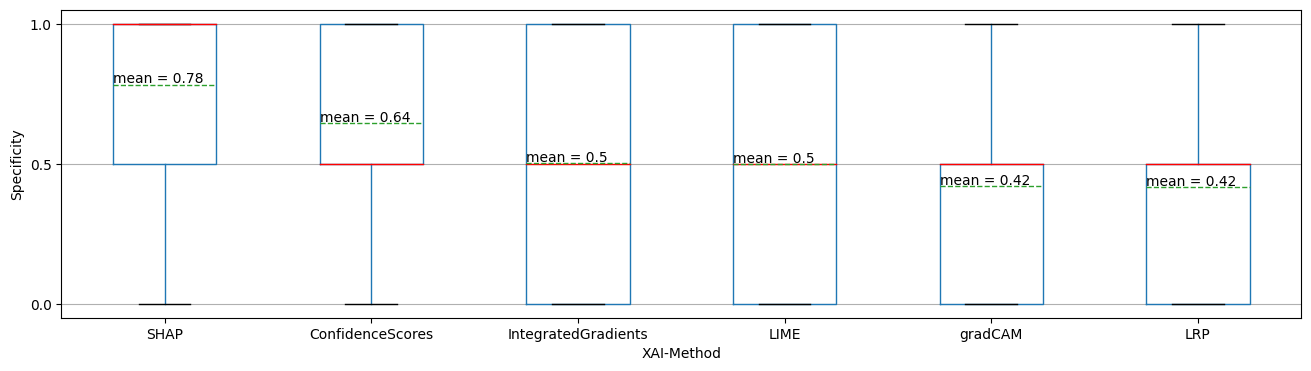

In [214]:
plot_metric_boxplot(df_spec_pivot, ylabel="Specificity" ,title="")

### Specificity convergence

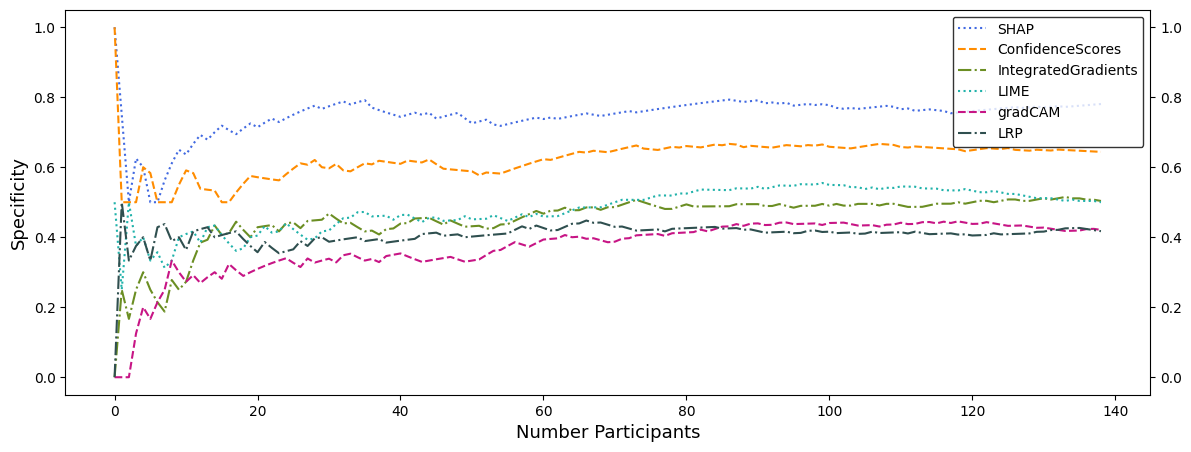

In [215]:
plot_metric_convergence(df_spec_conv, metric_name="Specificity")

### Specificity values frequencies (all possible discrete according to question resolution)

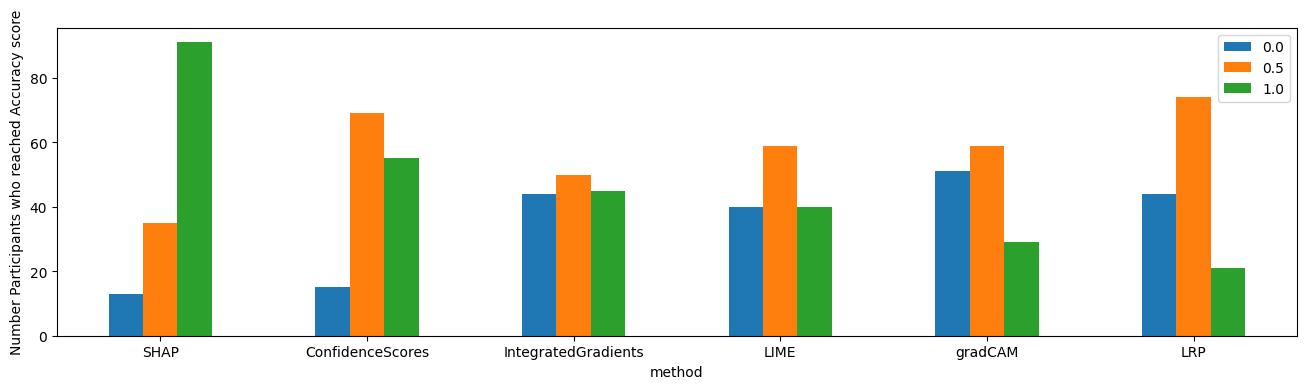

In [216]:
plot_metric_value_frequencies(df_spec_frequencies, df_spec_mean)

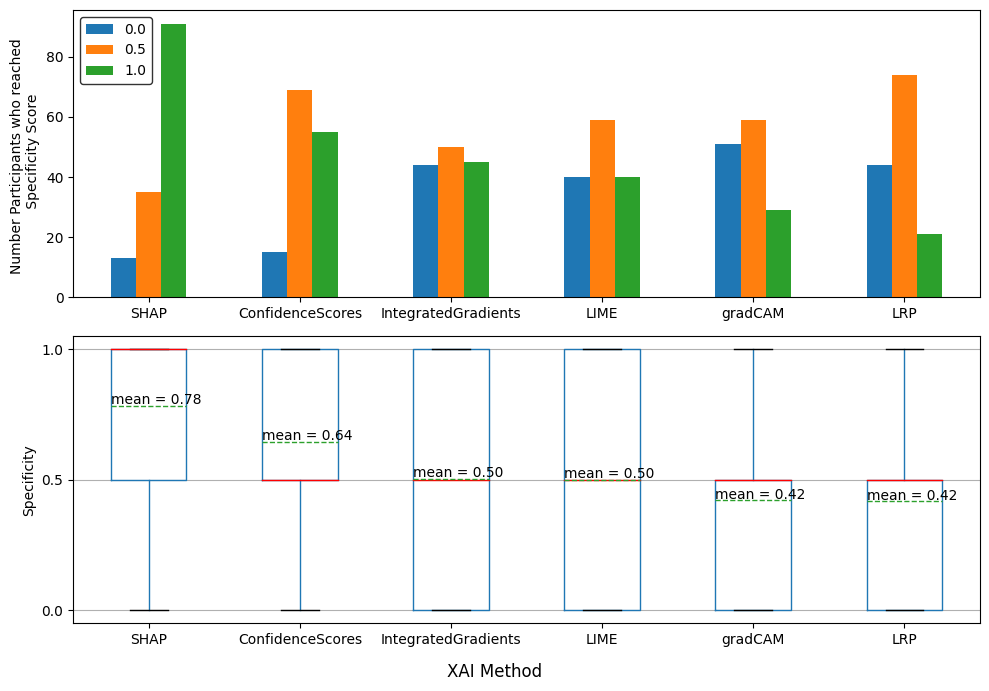

In [217]:
plot_metric_freq_and_boxplot(df_spec_frequencies, df_spec_mean, df_spec_pivot, metric="Specificity")

### Significance & Effect Size: Specificity comparisons to random baseline

In [248]:
df_spec_mean

,mean
method,
SHAP,0.780576
ConfidenceScores,0.643885
IntegratedGradients,0.503597
LIME,0.500000
gradCAM,0.420863
LRP,0.417266


#### 1-sample t-test

In [218]:
# test with flexibile alternative
ser_spec_1_sample_t_values = df_spec_pivot.apply(lambda metric_method: perform_t_test_with_flexible_alternative(metric_method, mean_h_0, ALPHA))

ConfidenceScores:  sample_mean=0.6438848920863309
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

IntegratedGradients:  sample_mean=0.5035971223021583
H0: sample_mean <= 0.5
p-value: 0.458
CAN'T reject H0: (alpha=0.05)

LIME:  sample_mean=0.5
H0: sample_mean equal 0.5
p-value: 1.0
CAN'T reject H0: (alpha=0.05)

LRP:  sample_mean=0.4172661870503597
H0: sample_mean >= 0.5
p-value: 0.002
Reject H0! (alpha=0.05)

SHAP:  sample_mean=0.7805755395683454
H0: sample_mean <= 0.5
p-value: 0.0
Reject H0! (alpha=0.05)

gradCAM:  sample_mean=0.420863309352518
H0: sample_mean >= 0.5
p-value: 0.007
Reject H0! (alpha=0.05)



In [219]:
# overall test
df_spec_overall = df_spec_pivot.mean(axis=1)
t_spec_overall = perform_t_test(df_spec_overall, mean_h_0, ALPHA, "greater")
effect_spec_overall = cohens_d(t_spec_overall, len(df_spec_overall))
effect_spec_overall

None
p-value: 0.002
Reject H0: accuracy_mean <= 0.5 



0.2560432122239982

In [220]:
df_spec_overall.mean()

0.5443645083932853

#### Effect size (Cohens d) 

In [221]:
N_spec = df_spec_pivot.shape[0]
df_spec_1_sample_effect = ser_spec_1_sample_t_values.map(lambda t_val: cohens_d(t_val, N_sens)).to_frame("cohens_d").sort_values(by="cohens_d", ascending=False)

In [222]:
df_spec_1_sample_effect.round(2)

,cohens_d
method,
SHAP,0.85
ConfidenceScores,0.44
IntegratedGradients,0.01
LIME,0.00
gradCAM,-0.21
LRP,-0.25


### Significance: Specificity pairwise between in each other

#### Paired t-test

In [237]:
df_spec_mean

,mean
method,
SHAP,0.780576
ConfidenceScores,0.643885
IntegratedGradients,0.503597
LIME,0.500000
gradCAM,0.420863
LRP,0.417266


In [232]:
df_spec_paired_test_alternatives, df_spec_paired_test_pvalues, df_spec_paired_decision = get_pairwise_paired_test_results(df_spec_pivot, df_spec_mean, ALPHA)


In [233]:
df_spec_paired_test_alternatives

,SHAP,ConfidenceScores,IntegratedGradients,LIME,gradCAM,LRP
SHAP,—,$>$,$>$,$>$,$>$,$>$
ConfidenceScores,$<$,—,$>$,$>$,$>$,$>$
IntegratedGradients,$<$,$<$,—,$>$,$>$,$>$
LIME,$<$,$<$,$<$,—,$>$,$>$
gradCAM,$<$,$<$,$<$,$<$,—,$>$
LRP,$<$,$<$,$<$,$<$,$<$,—


In [238]:
print(df_spec_paired_test_alternatives.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} & SHAP & ConfidenceScores & IntegratedGradients & LIME & gradCAM &  LRP \\
\midrule
SHAP                &    — &              $>$ &                 $>$ &  $>$ &     $>$ &  $>$ \\
ConfidenceScores    &  $<$ &                — &                 $>$ &  $>$ &     $>$ &  $>$ \\
IntegratedGradients &  $<$ &              $<$ &                   — &  $>$ &     $>$ &  $>$ \\
LIME                &  $<$ &              $<$ &                 $<$ &    — &     $>$ &  $>$ \\
gradCAM             &  $<$ &              $<$ &                 $<$ &  $<$ &       — &  $>$ \\
LRP                 &  $<$ &              $<$ &                 $<$ &  $<$ &     $<$ &    — \\
\bottomrule
\end{tabular}



/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_77024/2299405567.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_spec_paired_test_alternatives.to_latex(escape=False))


In [234]:
df_spec_paired_test_pvalues

,SHAP,ConfidenceScores,IntegratedGradients,LIME,gradCAM,LRP
SHAP,—,$<$ .001,$<$ .001,$<$ .001,$<$ .001,$<$ .001
ConfidenceScores,$<$ .001,—,$<$ .001,$<$ .001,$<$ .001,$<$ .001
IntegratedGradients,$<$ .001,$<$ .001,—,.47,.026,.025
LIME,$<$ .001,$<$ .001,.47,—,.028,.021
gradCAM,$<$ .001,$<$ .001,.026,.028,—,.466
LRP,$<$ .001,$<$ .001,.025,.021,.466,—


In [239]:
print(df_spec_paired_test_pvalues.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} &      SHAP & ConfidenceScores & IntegratedGradients &      LIME &   gradCAM &       LRP \\
\midrule
SHAP                &         — &         $<$ .001 &            $<$ .001 &  $<$ .001 &  $<$ .001 &  $<$ .001 \\
ConfidenceScores    &  $<$ .001 &                — &            $<$ .001 &  $<$ .001 &  $<$ .001 &  $<$ .001 \\
IntegratedGradients &  $<$ .001 &         $<$ .001 &                   — &       .47 &      .026 &      .025 \\
LIME                &  $<$ .001 &         $<$ .001 &                 .47 &         — &      .028 &      .021 \\
gradCAM             &  $<$ .001 &         $<$ .001 &                .026 &      .028 &         — &      .466 \\
LRP                 &  $<$ .001 &         $<$ .001 &                .025 &      .021 &      .466 &         — \\
\bottomrule
\end{tabular}



/var/folders/w5/m5wrj2m93qscdptzjbh3khlr0000gn/T/ipykernel_77024/181924832.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_spec_paired_test_pvalues.to_latex(escape=False))


In [236]:
df_spec_paired_decision

,SHAP,ConfidenceScores,IntegratedGradients,LIME,gradCAM,LRP
SHAP,False,True,True,True,True,True
ConfidenceScores,True,False,True,True,True,True
IntegratedGradients,True,True,False,False,True,True
LIME,True,True,False,False,True,True
gradCAM,True,True,True,True,False,False
LRP,True,True,True,True,False,False


## 4. Accuracy vs. Sensitivity vs. Specificity per method

In [ ]:
plot_acc_sens_spec(df_acc_mean, df_sens_mean, df_spec_mean, title_addition="")

In [ ]:
test = df_acc_mean.sort_values("mean").index

In [ ]:
df_acc_mean.reindex(test)

In [ ]:
df_acc_mean

#### Sensitvity/ Specificity only on fixed images

In [ ]:
fixed_img_idxs = df_quest_meta["img_idx"].value_counts()[df_quest_meta["img_idx"].value_counts() == 12].index
df_quest_meta_fixed = df_quest_meta[df_quest_meta["img_idx"].isin(fixed_img_idxs)]

## 5. Analysis: Participants characteristics on accuracy

### Accuracy for different education levels

In [ ]:
df_accuracy_edu_method = accuracy_per_groupby(df_merged, group_by=["Education", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_edu_method, "XAI Method", "Accuracy", "Accuracy Scores for different XAI Methods for different Education Levels")

In [ ]:
bar_plot(df_accuracy_edu_method,"education")

### Accuracy for different ML-Experience

In [ ]:
df_accuracy_mlex_method = accuracy_per_groupby(df_merged, group_by=["ML Experience", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_mlex_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different ML Experience Length", mean_idx_order=["Not at all", "Under 1 year", "Between 1 and 3 years", "Between 3 and 5 years", "More than 5 years"])

In [ ]:
bar_plot(df_accuracy_mlex_method,"ml_exp")

### Accuracy for different perceived ML-Experience Usefulness

In [ ]:
df_accuracy_xaiusef_method = accuracy_per_groupby(df_merged, group_by=["ML Experience Usefulness", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_xaiusef_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different perceived ML-Experience Usefulness")

In [ ]:
bar_plot(df_accuracy_xaiusef_method,"ml_exp_self")

### Accuracy for visual impairment

In [ ]:
df_accuracy_visimp_method = accuracy_per_groupby(df_merged, group_by=["Visual Impairment Affect", "method"], drop_na=True)

In [ ]:
plot_2_indexes_1_plot(df_accuracy_visimp_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Visual Impairment Affect", drop_duplicates=True)

In [ ]:
bar_plot(df_accuracy_visimp_method,"visual")

### Accuracy for colorblindness yes/no

In [ ]:
df_accuracy_colorb_method = accuracy_per_groupby(df_merged, group_by=["Color Blindness", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_colorb_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Color Blindness", drop_duplicates=True)

## 6. Accuracy for different models

In [ ]:
df_accuracy_model_method = accuracy_per_groupby(df_merged, group_by=["model", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_model_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Models", drop_duplicates=False)

In [ ]:
line_plot(df_accuracy_model_method, "XAI Method", "Accuracy","models")

## 7. Metrics per questionnaire form (detect outlier questionnaires)

In [ ]:
df_accuracy_qustnr_method = accuracy_per_groupby(df_merged, group_by=["QUESTNNR", "method"])

In [ ]:
plot_2_indexes_1_plot(df_accuracy_qustnr_method, "XAI Method", "Accuracy", "Comparing Accuracy Scores for different Questionnaire Forms")

## (PRÄSI) User demographical answers to excel 

In [ ]:
df_merged

In [ ]:
df_demo = df_merged.drop_duplicates(subset=["case"])

In [ ]:
df_demo.groupby("Education")["case"].count().to_frame().T.to_excel("education.xlsx")

In [ ]:
df_demo.groupby("ML Experience")["case"].count().to_frame().T.to_excel("mlexp.xlsx")

In [ ]:
df_demo.groupby("ML Experience Usefulness")["case"].count().to_frame().T.to_excel("mlexpUse.xlsx")

In [ ]:
df_demo.groupby("Color Blindness: Yes")["case"].count().to_frame().T.to_excel("colorblind.xlsx")